In [33]:
"""Lennard-Jones for specific atom"""

import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from make_animation import make_3d_animation

class atom_props():
    """Redunant calss, can be deleted 
    Sets atom properties
    
    Parameters: 
    -----------
    sigma: float
        sigma of the atom, self.sig
    epsilon: float
        epsilon of atom, self.eps
    mass: floast
        mass of the atom, self.m
    
    """
    def __init__(self, sigma, epsilon, mass):
        self.sig = sigma
        self.eps = epsilon
        self.m = mass

def pot_LJ(atom,r):
    """Regular Lenard Jones potential, based on atom properties and distance"""
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    """Dimensionless Lenard Jones potential, based on distances"""
    r = r**-6 # Possibly improves speed
    u = 4*(r**2 - r)        
    return u

def grad_pot_LJ_dl(r):
    """Diff of the Lennard Jones potential wrt r, dimensionless"""
    return (-48*r**-6 + 24)*r**-7 

def particle_generator(lattice, L, N, dim):
    """Generates initial particle position and velocity.
    
    Parameters:
    -----------
    lattice: string
        random: arbitrary ammount of particles and dimensions randomly distributed 
        fcc: 3d 4 particles on fcc lattice 
    L: float
        size of the simulation box
    N: int
        Number of particles, should be n^3 where n is the amount of boxes in one direction
    dim: int
        Number of dimensions, should be 3 for fcc     
    """
    if lattice == "random":
        x_init = np.random.random((dim,N))*L
        
    if lattice == "fcc":
        
        if (unit_cells == unit_power**3) and dim == 3:
            # Primitive unit cell coordinates for fcc
            initial_unit_cell = np.array([[0,0,unit_size/2,unit_size/2],
                                          [0,unit_size/2,0,unit_size/2],
                                          [0,unit_size/2,unit_size/2,0]])
            
            # Create list width 1d coordinate of every starting cell
            a =[]
            for p in range(unit_power):
                a.append([unit_size*p])
            
            # Create a 1d grid of all unit cell corners
            arr = np.array([arr.flatten() for arr in np.meshgrid(a,a,a)])
            
            # Create array with all the translated unit cell coordinates
            fcc_coordinates = np.array([[],[],[]])
            for j in range(unit_power**3):
                tempor = arr[:, j].reshape(dim,1) + initial_unit_cell 
                fcc_coordinates = np.concatenate([fcc_coordinates, tempor], axis = 1)

            x_init = fcc_coordinates
            
        else:
            print('The dimension is not equal to 3 or the number of particles doesnt equal four.')
            import sys
            sys.exit()
            
    # v_init = np.zeros((dim,N),dtype=float)
    # Initial velocity chosen gaussian
    v_init = np.random.normal(0, np.sqrt(T), (dim,N))
    v_init = v_init - v_init.sum(axis = 1).reshape(3,1)/N #remove net velocity from the system
    return x_init, v_init


def particle_dist(L, N, x, dim):
    """"Calculate distances between NN particle pairs
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    x: array of size (dim, N)
        Particle places   
    dim: int
        Number of dimensions  
    """
    # Calculate distances to NN
    r = np.zeros((N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N),dtype=float)
    NN_max_dist = L/2       
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        
        # New difference including 'virtu=al' coordinates
        delta[delta >= NN_max_dist] = -(L-delta[delta >= NN_max_dist])
        delta[delta < -NN_max_dist] = (L + delta[delta < -NN_max_dist])
        delta_tot[i] = delta
        r += delta**2   
    r = np.sqrt(r) 
    r[r == 0] = np.inf
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    """Calculate forces between particles based on potential
    
    Parameters:
    -----------
    delta_tot: array of size (dim, N, N)
        Differenes between particles
    r: array of size (N, N)
        inter particle distances
    dim: int
        Number of dimensions  
    N: int
        Number of particles
    """
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = sum(pot_LJ_dl(r).sum(axis=1))
    Force_grad = -grad_pot_LJ_dl(r)
    for i in range(dim):
        F[i] = Force_grad*delta_tot[i]/r
    
    F_sum = F.sum(axis=1)
    return F_sum, U

def xv_iteration(algorithm, x, v, F_tot_old, L, N, dim):
    """Euler or verlet arlgorithm for position and velocity
    
    Parameters:
    -----------
    algorithm: string
        verlet or euler, determinse the iterative process used
    x: array of size (dim,N)
        positions of all the particles
    v: array of size (dim,N)
        speed of all the particles
    F_tot_old: array of size (dim, N)
        total force on the particles, per particle at time step t, t + dt is calculated in this function
    L: float
        size of the simulation box
    N: int
        Number of particles
    dim: int
        Number of dimensions 
    """
    
    if algorithm == "euler":
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        x = (x + v * delta_t)%L
        v = v + F_tot * delta_t
        
    if algorithm == "verlet":
        x = (x + v * delta_t + 0.5*delta_t**2 * F_tot_old)%L
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        v = v + 0.5*delta_t * (F_tot + F_tot_old)
            
    return x, v, F_tot, U.sum(), r

def temp_check(E_kin, E_pot, v, T_tot, i, conf_level, check_time, sum_past, last_renorm_time):
    '''Determines if the temperature of the system agress 
    with the setup temperature, if not a renormalization 
    of the velocity is applied to correct for the kinetic energy
    
    Parameters:
    -----------
    E_kin: array of size (loop iteration i) 
        kinetic energy of the particles
    E_pot: array of size (loop iteration i)
        potential energy of the particles
    v: array of size (dim, N)
        particle velocity's
    T_tot: array of size (loop iteration)
        all past temeratures of the system
    i: int
        gives the loop iteration
    
    '''
    past_period = int(i-0.7*i)
    T_ave = (T_tot[i-past_period:i].sum())/past_period
    T_squ = (((T_tot[i-past_period:i])**2).sum())/past_period
    T_std = np.sqrt(T_squ - (T_ave)**2)  
    if (T < T_ave - conf_level*T_std or T > T_ave + conf_level*T_std):
        last_renorm_time = cp.deepcopy(i)
        lam = np.sqrt(((N-1)*3*T)/(2*E_kin[i]))
        v = lam * v
        renorm_check = True
    renorm_check = False
    return v, last_renorm_time, renorm_check

def pot_calc(U, v):
    '''Calculates the total energy of the system, potential and kinetic.
    
    Parameters:
    -----------
    U: array of size (N, N)
        potential interaction energy of all particles
    v: array of size (dim, N)
        velocit's of the particles
    '''
    E_pot = 0.5*U.sum()
    E_kin = 0.5*(v**2).sum(axis=1).sum(axis=0)
    return E_kin, E_pot
    

In [36]:
# Initialization

# Parameters
T = 3 # Kelvin /119.8
density = 0.7

# Initial positions
unit_power = 3
unit_cells = unit_power**3
N_unit = 4 # 4 partciles per unit cell
unit_size = (N_unit/density)**(1/3)
L = unit_size*(unit_power) # Box size
N = N_unit*unit_cells 
dim = 3 # Dimensions of the probem

lattice = "fcc" # fcc or random
algorithm = "verlet" #euler or velvet

x_init, v_init = particle_generator(lattice,L, N, dim)


In [37]:
# Main program
import time

start_time = time.time()

delta_t = 4e-3
t_max = 2000*delta_t

conf_level = 1 # amount of standard deviations from the average temp
inter_numb = 2 # Number of interactions per particle

t_range = np.arange(0, t_max, delta_t)
x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

pos = np.zeros((len(t_range),N,dim),dtype=float)
vel = np.zeros((len(t_range),N,dim),dtype=float)
force = np.zeros((len(t_range),N,dim),dtype=float)
differ = np.zeros((len(t_range),N,N),dtype=float)

delta_tot, r = particle_dist(L, N, x, dim)
F_tot, U = pot_and_force(delta_tot, r, dim, N)

E_pot = np.zeros((len(t_range),1),dtype=float)
C_v = np.zeros((len(t_range),1),dtype=float)
E_kin = np.zeros((len(t_range),1),dtype=float)
T_tot = np.zeros((len(t_range),1),dtype=float)
N_inter = np.zeros((len(t_range),1),dtype=float)
Sum_rF = np.zeros((len(t_range),1),dtype=float)
last_renorm_time = 0

l_mfp = 1/N*(L**dim)/(np.pi*N*(1**(dim-1))) #mean free path per particle
sum_past = 0

N_inter_tot = 0
renorm_count = 0
for i, t in enumerate(t_range):
    
    E_kin[i], E_pot[i] = pot_calc(U, v)
    T_tot[i] = ((2*E_kin[i])/(3*(N-1)))
    
    t_mfp = l_mfp/(np.sqrt(2*E_kin[i]/N))
    N_inter_tot += delta_t/t_mfp
    
    # Make this dependant on the particle speed
    if N_inter_tot > inter_numb*N and renorm_count < 10:
        v, last_renorm_time, renorm_check = temp_check(E_kin, E_pot, v, T_tot, i, conf_level, t, sum_past, last_renorm_time)
        
        if renorm_check == False:
            renorm_count += 1
            
        N_inter_tot = 0
        sum_past = cp.deepcopy(i) #redundant? -> no
    
    x, v, F_tot, U, r = xv_iteration(algorithm, x, v, F_tot, L, N, dim)
    
    Sum_rF[i] = np.sum(np.sum(x*F_tot, axis=0))
    force[i,:,:] = F_tot.transpose()
    vel[i,:,:] = v.transpose()
    pos[i, :, :] = x.transpose()
    differ[i,:,:] = r
    
end_time = time.time()
print('Time:', end_time - start_time, 's')
 

Time: 6.870150566101074 s


In [5]:
# Bootstrapping
def btstrp_rnd_gen(trials, i, last_renorm_time):
    N = i-last_renorm_time
    a = np.round(np.random.random(trials*N).reshape(trials,N)*N+last_renorm_time)
    return a.astype(int)    

In [6]:
trials = 10 #bootstrap trials
btstrp_seq = btstrp_rnd_gen(trials, i, last_renorm_time)


In [7]:
# C_v
C_v = np.zeros((trials,1), dtype=float)
for j in range(trials):
    E_kin_ave = E_kin[btstrp_seq[j]].sum()/(i-last_renorm_time)
    fluc = (((E_kin[btstrp_seq[j]]-E_kin_ave)**2).sum()/(i-last_renorm_time))/E_kin_ave**2
    C_v[j] = 1/((2/(3*N))-fluc)/N
            
C_v_ave = C_v.sum()/trials
C_v_sig = np.sqrt((C_v**2).sum()/trials - C_v_ave**2)
print('C_v_ave =', C_v_ave)
print('C_v_sig =', C_v_sig)

#plt.plot(range(trials),C_v)
#plt.show()

C_v_ave = 2.04888520935
C_v_sig = 0.0245852571011


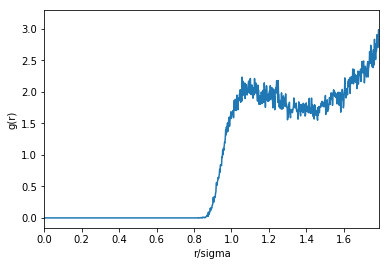

In [32]:
# auto correlation
from scipy import interpolate
trials = 1 #bootstrapping not needed?!?
btstrp_seq = btstrp_rnd_gen(trials, i, last_renorm_time)

bin_number = int(500*L)
hist_tot = np.zeros(bin_number-1,dtype=int)
for j in range(trials):
    diff_subset = differ[btstrp_seq[j]]
    hist, bin_edges = np.histogram(diff_subset[diff_subset!=np.inf], bins = np.linspace(0,L,bin_number))
    hist_tot += hist
    
hist_tot = hist_tot/trials/(N*(N-1))
plt.plot(bin_edges[:-1],hist_tot)
plt.xlim([0,L/2])
plt.ylabel('g(r)')
plt.xlabel('r/sigma')
plt.show()


In [9]:
# Pressure determination (dimensionless version)

'''According to eq. 7.36 in Jos' book (beta*P/n)'''

trials = 100
btstrp_seq = btstrp_rnd_gen(trials, i, last_renorm_time)
P = np.zeros((trials,1),dtype=float)

for j in range(trials):
    Sum_rF_ave = Sum_rF[btstrp_seq[j]].sum()/(i-last_renorm_time)
    P[j] = 1+1/(3*N*T)*Sum_rF_ave
            
P_ave = P.sum()/trials
P_sig = np.sqrt((P**2).sum()/trials - P_ave**2)
print('P_ave =', P_ave)
print('P_sig =', P_sig)

P_ave = 1.07869515925
P_sig = 0.028956674656


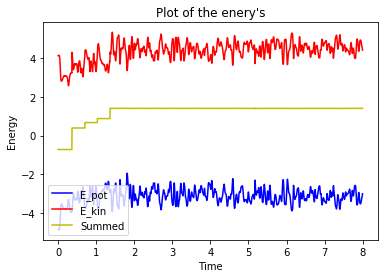

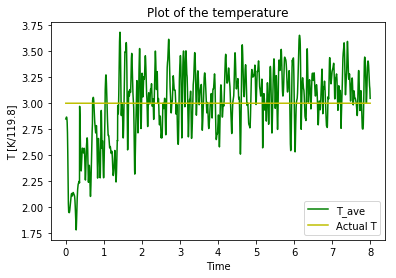

In [10]:
# Plotting of energy and temperature


plt.plot(t_range,E_pot/N,'b')
plt.plot(t_range,E_kin/N,'r')
plt.plot(t_range,(E_kin+E_pot)/N,'y')
plt.legend(['E_pot','E_kin','Summed'])
plt.title("Plot of the enery's")
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

plt.plot(t_range,T_tot,'g')
plt.plot(t_range,np.ones((len(t_range),1),dtype=float)*T,'y')
plt.legend(['T_ave','Actual T'])
plt.title("Plot of the temperature")
plt.xlabel('Time')
plt.ylabel('T [K/119.8]')
plt.show()



In [11]:
# Make an animation

from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=10, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())